### Imports

In [1]:
import numpy as np
import pandas as pd
import data.data_generator as dg
import importlib
import matplotlib.pyplot as plt
import matplotlib
from pathlib import Path
import os
import string
import random
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel as C
import pandas as pd
import julian
import datetime

### Data Download

In [55]:
#HE0435
CosmoGrail = pd.read_table('CosmoGrail.txt')

t = CosmoGrail['mhjd'].values[1:].astype('float')
A = CosmoGrail['mag_A'].values[1:].astype('float')
dA = CosmoGrail['magerr_A'].values[1:].astype('float')
B = CosmoGrail['mag_B'].values[1:].astype('float')
dB = CosmoGrail['magerr_B'].values[1:].astype('float')
C_ = CosmoGrail['mag_C'].values[1:].astype('float')
dC_ = CosmoGrail['magerr_C'].values[1:].astype('float')
D = CosmoGrail['mag_D'].values[1:].astype('float')
dD = CosmoGrail['magerr_D'].values[1:].astype('float')

### Print some light curve pairs

<IPython.core.display.Javascript object>


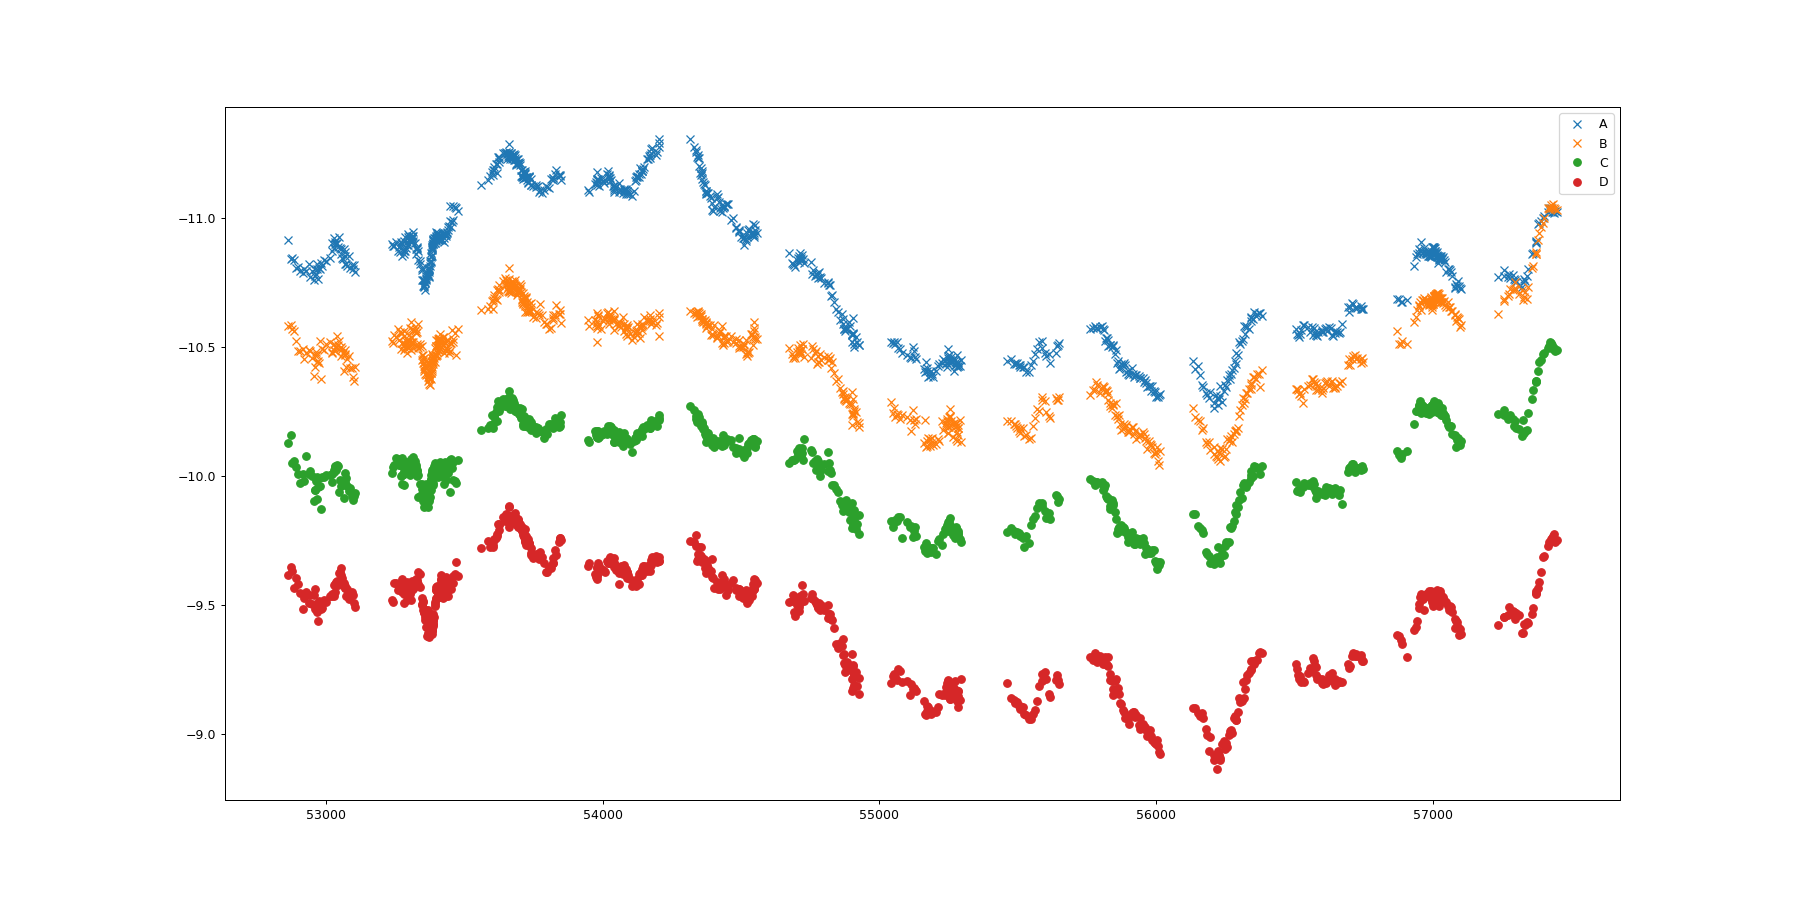

In [4]:
%matplotlib notebook
plt.figure(figsize=(20,10))
plt.plot(t,A,'x', label = 'A')
plt.plot(t,B,'x', label = 'B')
plt.plot(t,C_, 'o', label = 'C')
plt.plot(t,D, 'o', label = 'D')
plt.gca().invert_yaxis()
plt.legend()
plt.show()

### GP Regression
In the regression difference method, a Gaussian process regression is performed on each quasar image light curve independently. The regressions are then shifted in time and subtracted
pair-wise, resulting in one difference curve for each pair of light
curves and its associated uncertainties envelope. The algorithm
minimises the variability of the difference curves by varying the
time shift.

In practice, for each of the n light curves, we evaluate the
GPR every 0.2 days. Given some trial time shifts, we express
the n (n − 1)/2 difference curves by subtracting linearly interpolated magnitudes of the shifted regression curves. Indeed, each
pair of curves has to be considered only once; for the variability


In [263]:
kernel = C(0.1, (1e-3, 1e2)) * RBF(200, (1e-1, 5e2))
kernel2 = C(2, (1e-3, 1e2)) * Matern(length_scale=200.0, length_scale_bounds=(1, 300), nu=1.5)
gp1 = GaussianProcessRegressor(kernel=kernel2, alpha=dA**2,
                              n_restarts_optimizer=10, optimizer = 'fmin_l_bfgs_b', normalize_y =True)
gp2 = GaussianProcessRegressor(kernel=kernel2, alpha=dB**2,
                              n_restarts_optimizer=10, optimizer = 'fmin_l_bfgs_b', normalize_y =True)


gp1.fit(np.expand_dims(t,1), A)
gp2.fit(np.expand_dims(t,1), B)

GaussianProcessRegressor(alpha=array([3.6864000e-04, 5.7121000e-04, 2.8900000e-04, 3.2400000e-04,
       6.6564000e-04, 3.2400000e-04, 5.0176000e-04, 4.7089000e-04,
       4.0000000e-04, 3.2400000e-04, 2.7889000e-04, 4.1616000e-04,
       2.5600000e-04, 3.5521600e-03, 3.2400000e-04, 4.3264000e-04,
       2.5281000e-04, 3.6100000e-04, 5.1529000e-04, 9.4864000e-04,
       3.4225000e-04, 3.6100000e-04, 1.02...
       9.7969000e-06, 7.8400000e-06, 8.6304100e-05, 1.6974400e-05,
       2.7457600e-05, 9.0000000e-06, 1.7724100e-05, 1.5840400e-05,
       8.3521000e-06, 5.4760000e-05, 1.0432900e-05, 4.9984900e-05,
       1.9448100e-05, 2.9052100e-05, 1.7640000e-05, 1.1424400e-05]),
                         copy_X_train=True,
                         kernel=1.41**2 * Matern(length_scale=200, nu=1.5),
                         n_restarts_optimizer=10, normalize_y=True,
                         optimizer='fmin_l_bfgs_b', random_state=None)

In [264]:
print(gp1.log_marginal_likelihood_value_)
print(gp2.log_marginal_likelihood_value_)
gp1.get_params

2165.3580144342936
1711.615336529264


<bound method BaseEstimator.get_params of GaussianProcessRegressor(alpha=array([1.7161000e-04, 2.7889000e-04, 1.4400000e-04, 1.4400000e-04,
       2.8224000e-04, 1.4400000e-04, 3.1329000e-04, 2.5281000e-04,
       1.6900000e-04, 1.4400000e-04, 1.3225000e-04, 2.5281000e-04,
       1.2100000e-04, 1.6974400e-03, 1.4400000e-04, 2.0736000e-04,
       1.3456000e-04, 1.4400000e-04, 2.4964000e-04, 5.5225000e-04,
       1.8496000e-04, 1.4400000e-04, 3.24...
       5.3361000e-06, 6.1504000e-06, 4.2250000e-05, 1.1902500e-05,
       7.3441000e-06, 1.1764900e-05, 1.2888100e-05, 1.4745600e-05,
       6.8644000e-06, 4.1990400e-05, 8.4681000e-06, 8.2369000e-06,
       1.5132100e-05, 6.5124900e-05, 5.6400100e-05, 1.5366400e-05]),
                         copy_X_train=True,
                         kernel=1.41**2 * Matern(length_scale=200, nu=1.5),
                         n_restarts_optimizer=10, normalize_y=True,
                         optimizer='fmin_l_bfgs_b', random_state=None)>

In [265]:
gp_step = 0.2
support = np.arange(t[0] - 5e1, t[-1] + 5e1,gp_step)
y_pred1, sigma1 = gp1.predict(np.expand_dims(support,1), return_std=True)
y_pred2, sigma2 = gp2.predict(np.expand_dims(support,1), return_std=True)

### Plot Regression results

<IPython.core.display.Javascript object>


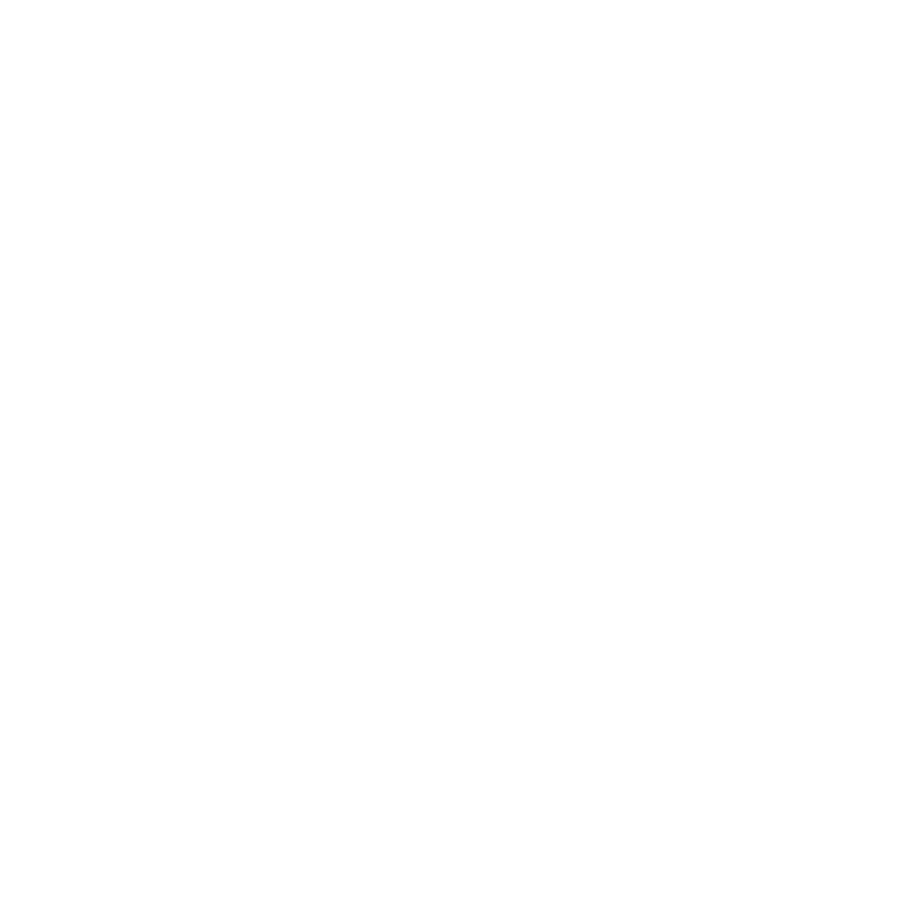

In [266]:
%matplotlib notebook
plt.figure(figsize=(10,10))
plt.plot(np.expand_dims(t,1), B, 'g.', markersize=3, label='ObservationsB')
plt.plot(np.expand_dims(t,1), A, 'b.', markersize=3, label='ObservationsA')
plt.plot(np.expand_dims(support,1), y_pred1, 'b-', label='PredictionA')
plt.plot(np.expand_dims(support,1), y_pred2, 'g-', label='PredictionB')
plt.fill(np.concatenate([np.expand_dims(support,1), np.expand_dims(support,1)[::-1]]),
         np.concatenate([y_pred1 - 1.9600 * sigma1,
                        (y_pred1 + 1.9600 * sigma1)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval B')
plt.fill(np.concatenate([np.expand_dims(support,1), np.expand_dims(support,1)[::-1]]),
         np.concatenate([y_pred2 - 1.9600 * sigma2,
                        (y_pred2 + 1.9600 * sigma2)[::-1]]),
         alpha=.5, fc='g', ec='None', label='95% confidence interval A')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend(loc='upper left')
plt.gca().invert_yaxis()

### Plot shifted curves and difference

<IPython.core.display.Javascript object>


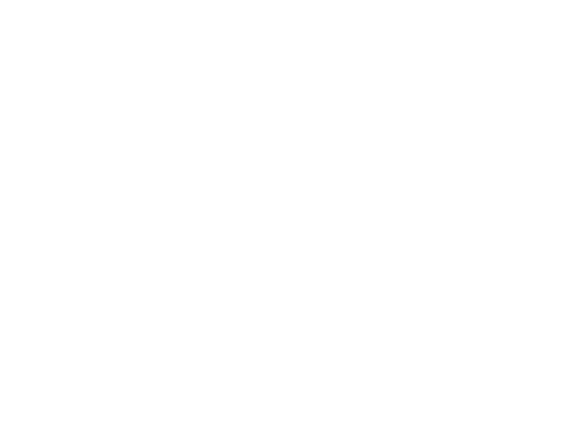

In [267]:
%matplotlib notebook
win = 1000
shift = 0
plt.plot(np.expand_dims(support,1)[win:-win],y_pred1[win:-win], color = 'g', label = 'A')
plt.plot(np.expand_dims(support,1)[win:-win],y_pred2[win+shift:-win+shift], color = 'b', label = 'B')
plt.legend()
plt.gca().invert_yaxis()

<IPython.core.display.Javascript object>


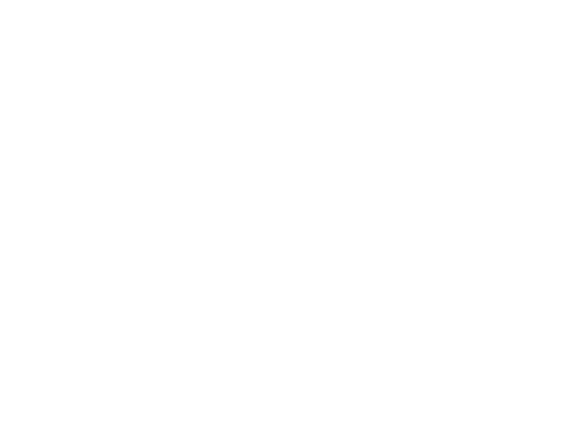

In [268]:
%matplotlib notebook
win = 1000
shift = 0
diff = y_pred1[win:-win]-y_pred2[win+shift:-win+shift]
sigma_diff = sigma1[win:-win] + sigma2[win+shift:-win+shift]
plt.plot(np.expand_dims(support,1)[win:-win],diff, color = 'b', label = 'Difference')
plt.fill(np.concatenate([np.expand_dims(support,1)[win:-win], np.expand_dims(support,1)[win:-win][::-1]]),
         np.concatenate([diff - 1.9600 * sigma_diff,
                        (diff + 1.9600 * sigma_diff)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval difference')
plt.legend()
plt.gca().invert_yaxis()

### Loss Function

In [269]:
%matplotlib notebook
def derivatives(f,sigma,gp_step):
    derivative_f = []
    weight = []
    for i in range(len(f)-1):
        derivative_f.append((f[i+1]-f[i])/gp_step)
        weight.append(2/(sigma[i]+sigma[i+1]))
    return np.array(derivative_f), np.array(weight)

def WAV(f,sigma,gp_step):
    f_prime,sigma_prime = derivatives(f,sigma,gp_step)
    WAV = np.dot(np.abs(f_prime), sigma_prime)/np.sum(sigma_prime)
    return WAV

WAV(diff,sigma_diff,gp_step)

0.001891547680580292

### Simple Test
Simple Grid-search. Better results can be probably obtained with an out-of-the-box nonlinear optimizer

In [270]:
win = 100
shift = np.arange(0,100,1)
WAV_values = []
for i in shift:
    diff = y_pred1[win:-win]-y_pred2[win+i:-win+i]
    sigma_diff = sigma1[win:-win] + sigma2[win+i:-win+i]
    WAV_values.append(WAV(diff,sigma_diff,gp_step))
print('Estimated delay: ', np.argmin(WAV_values)*gp_step)

Estimated delay:  8.4


### Summary

In [271]:
#BD ------> -6.80    (Milton2020: -5.4 ± 0.8)  (Courbin2011: -6.5 ± 0.7) 
#AD ------> -13.2   (Milton2020: -13.8 ± 0.9)  (Courbin2011: -14.9 ± 2.1) 
#AB ------> -8.4    (Milton2020: -9.0 ± 0.8)  (Courbin2011: -8.4 ± 2.1) 
#AC ------>  0.2  (Milton2020: -0.8 ± 0.7)  (Courbin2011: 0.6 ± 2.3) 
#BC ------>  +8.0   (Milton2020: +7.8 ± 0.9)  (Courbin2011: +7.8 ± 0.8) 
#CD ------>  -13.2   (Milton2020: -13.2 ± 0.8)  (Courbin2011: -14.3 ± 0.8)